# Sparkify project - Feature engineering 
In the previous notebook, an extensive data exploration has been done to identify the different information in the dataset and how the information spreads and varies across users. Some categorical variables could be extracted from parsing some of the fields such as State or Device/experience used to access the platform. 
The user registration date distribution has also shown a wide distribution across the users.
In this notebook, I will combine all the categorical features pertaining to a given users, I will add also behavioral data aggregated at session level and build the feature dataset. 
An exploration of the features with respect to churn will be done too. 
This step is preliminary to the modeling of churn prediction.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import udf, concat, lit, col , explode, array, least, dense_rank
from pyspark.sql.functions import isnan, when
from pyspark.sql.functions import sum as Fsum 
from pyspark.sql.functions import min as Fmin
from pyspark.sql.functions import max as Fmax
from pyspark.sql.functions import unix_timestamp, to_timestamp, datediff
from pyspark.sql.functions import avg, stddev , count
from pyspark.sql.functions import asc, desc, log
from pyspark.sql.types import IntegerType, StringType, DoubleType, LongType, BooleanType, TimestampType, DateType
from pyspark.ml.feature import RegexTokenizer, VectorAssembler, MinMaxScaler
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier, LinearSVC, LogisticRegression, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt 
import seaborn as sns 
import scipy.stats as sp
from datetime import datetime as dt 
from datetime import timedelta as td
import itertools
import time

In [2]:
# create a Spark session
spark = SparkSession.builder \
        .master("local") \
        .appName("Sparkify") \
        .getOrCreate()

In [3]:
# Utility functions
def load_df(filename):
    df = spark.read.json(data_path)
    df.persist()
    return df 

def drop_null_userId(df):
    df = df.filter("userId <> ''")
    return df 

# Creating device type
def get_device_type(x):
    if 'Macintosh' in x:
        return 'Mac'
    elif 'Windows' in x:
        return 'Windows'
    elif 'Linux' in x:
        return 'Android'
    elif 'iPhone' in x:
        return 'iPhone'
    elif 'iPad' in x:
        return 'iPad'
    else: 
        return 'Unknown'

get_device_udf = udf(lambda x:get_device_type(x), StringType())

def take_last_2_char(x):
    return x[-2:]
take_last_2_char_udf = udf(lambda x:take_last_2_char(x), StringType())

def add_columns(df):
    df = df.withColumn('device',get_device_udf(col('userAgent')))
    df = df.withColumn('experience',when(col('device').isin(['iPhone','iPad','Android']), 'Mobile').otherwise('Desktop'))
    df = df.withColumn('location_state', take_last_2_char_udf(col('location')))
    df = df.withColumn('state_group',when(~col('location_state').isin(['CA','TX','PA','FL']),'others').otherwise(col('location_state')))
    return df 
    

def clean_df(df):
    # drop rows where userId is null
    df = drop_null_userId(df)
    
    # convert timestamps fields to datetime with timestamp
    from_ts_to_date = udf(lambda x: dt.fromtimestamp(x / 1000.0), TimestampType())
    df = df.withColumn('registration_date', from_ts_to_date(col('registration')))
    df = df.withColumn('event_date', from_ts_to_date(col('ts')))
    
    # Adding minimum and maximum timestamp of activities per user
    df = df.withColumn('min_event_date', Fmin(col('event_date')).over(Window.partitionBy('UserId')))
    df = df.withColumn('max_event_date', Fmax(col('event_date')).over(Window.partitionBy('UserId')))
    
    # Getting the corrected registration date for users starting to use the platform before registration date.
    df = df.withColumn('registration_date_cor', least(col('registration_date'),col('min_event_date')))

    # Dropping users acquired after the start of the data collection window
    data_min_date = df.select('min_event_date').agg(Fmin('min_event_date')).collect()[0][0]
    df = df.where(col('registration_date_cor') <= data_min_date)
    
    return df 

def save_df_to_json(df, path):
    df.write.json(path)

# Loading and cleaning dataset

In [4]:
data_path = "mini_sparkify_event_data.json"

In [5]:
df = load_df(data_path)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [6]:
df = clean_df(df)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, registration_date: timestamp, event_date: timestamp, min_event_date: timestamp, max_event_date: timestamp, registration_date_cor: timestamp]

In [7]:
df = add_columns(df)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, registration_date: timestamp, event_date: timestamp, min_event_date: timestamp, max_event_date: timestamp, registration_date_cor: timestamp, device: string, experience: string, location_state: string, state_group: string]

In [8]:
df.select('userId').dropDuplicates().count()

220

# Feature extraction

In [9]:
# Creating the user list
features = df.select('userId').dropDuplicates()

## Categorical features

### Gender

In [10]:
gender = df.select('userId','gender')\
            .dropDuplicates()\
            .withColumn('gender_flag', when(col('gender')=='F',1).otherwise(0))\
            .drop('gender')\
            .withColumnRenamed('gender_flag','gender')
features = features.join(gender,on=['userId'], how='left')

# Feature extraction

### List of features to build
Over first X days of activity with X in [7, 14, 21], let's try to predict churn with the following features: 
- gender
- total number of active days
- total number of sessions
- total number of songs
- total listening length
- total number of thumbs-up
- total number of thumbs-down
- number of paid sessions
- total length of paid sessions
- number of free sessions
- total length of free sessions
- index free vs paid session 
- number of upgrades 
- number of downgrades 
- number of added friends
- number of errors
- number of help page visits 
- number of settings page visit

In [11]:
# adding 
data_max_date = df.select('event_date').agg(Fmax('event_date')).collect()[0][0]
df = df.withColumn('active_day', col("event_date").cast(DateType()))
df = df.withColumn('tenure',datediff(lit(data_max_date), col('registration_date_cor')))

In [12]:
# tenure 
tenure = df.select('userId','tenure').dropDuplicates()
features = features.join(tenure,on=['userId'], how='left')

In [14]:
# number of active days 
active_days = df.select('userId','active_day')\
                    .dropDuplicates()\
                    .groupby('userId')\
                    .count()\
                    .withColumnRenamed("count", "active_days_count")
features = features.join(active_days,on=['userId'], how='left')

In [15]:
# total number of sessions
session_count_per_user = df.select('userId','sessionId')\
                                .dropDuplicates()\
                                .groupby('userId')\
                                .count()\
                                .withColumnRenamed("count", "session_count")
features = features.join(session_count_per_user,on=['userId'], how='left')

In [16]:
# total number of songs per user
song_count_per_user = df.select('userId','active_day','song')\
                                .dropDuplicates()\
                                .groupby('userId')\
                                .count()\
                                .withColumnRenamed("count", "song_count")
features = features.join(song_count_per_user,on=['userId'], how='left')

In [17]:
# total length of active sessions
total_length = df.select('userId','length')\
                                .groupby('userId')\
                                .sum()\
                                .withColumnRenamed("sum(length)", "total_length")
features = features.join(total_length,on=['userId'], how='left')

In [19]:
# number of paid sessions
paid_sessions = df.select('userId', 'sessionId')\
                        .where(df.level == 'paid')\
                        .groupBy('userId')\
                        .count() \
                        .withColumnRenamed('count', 'paid_sessions')
features = features.join(paid_sessions,on=['userId'], how='left')

In [20]:
# length of paid sessions
paid_sessions_length = df.select('userId', 'length')\
                        .where(df.level == 'paid')\
                        .groupBy('userId')\
                        .sum() \
                        .withColumnRenamed('sum(length)', 'paid_sessions_length')
features = features.join(paid_sessions_length,on=['userId'], how='left')

In [21]:
# number of free sessions
free_sessions = df.select('userId', 'sessionId')\
                        .where(df.level == 'free')\
                        .groupBy('userId')\
                        .count() \
                        .withColumnRenamed('count', 'free_sessions')
features = features.join(free_sessions,on=['userId'], how='left')

In [22]:
# length of free sessions
free_sessions_length = df.select('userId', 'length')\
                        .where(df.level == 'free')\
                        .groupBy('userId')\
                        .sum() \
                        .withColumnRenamed('sum(length)', 'free_sessions_length')
features = features.join(free_sessions_length,on=['userId'], how='left')

In [23]:
# paid_session share
paid_session_share = paid_sessions.join(session_count_per_user, on=['userId'], how='left')\
                            .withColumn('paid_session_share',col('paid_sessions')/col('session_count'))\
                            .select('userId','paid_session_share')
features = features.join(paid_session_share,on=['userId'], how='left')

In [24]:
# page usage 
page_count = df.select("userId", "page").groupBy("userId").pivot("page") \
    .count().drop("Cancel", "Cancellation Confirmation").fillna(0)
page_count.persist()

DataFrame[userId: string, About: bigint, Add Friend: bigint, Add to Playlist: bigint, Downgrade: bigint, Error: bigint, Help: bigint, Home: bigint, Logout: bigint, NextSong: bigint, Roll Advert: bigint, Save Settings: bigint, Settings: bigint, Submit Downgrade: bigint, Submit Upgrade: bigint, Thumbs Down: bigint, Thumbs Up: bigint, Upgrade: bigint]

In [25]:
features = features.join(page_count, on=['userId'], how='left')

In [26]:
df = df.withColumn('churn', when(df.page == 'Cancellation Confirmation', 1)\
                       .otherwise(0))
df = df.withColumn('user_churn_flag', Fmax('churn').over(Window.partitionBy('UserId')))
label = df.select('userId','user_churn_flag').dropDuplicates()

In [27]:
features = features.na.fill(0)
final_dataset = features.join(label,on=['userId'],how='left')

In [28]:
save_df_to_json(final_dataset,'mini_sparkify_features.json')

In [31]:
final_dataset.select('userId','gender','tenure','active_days_count','session_count','song_count','total_length','paid_session_share').show(5)

+------+------+------+-----------------+-------------+----------+------------------+------------------+
|userId|gender|tenure|active_days_count|session_count|song_count|      total_length|paid_session_share|
+------+------+------+-----------------+-------------+----------+------------------+------------------+
|100010|     1|    67|                7|            7|       281| 66940.89735000003|               0.0|
|200002|     0|    88|                8|            6|       393| 94008.87593999993|              59.0|
|   125|     0|   124|                1|            1|         9|2089.1131000000005|               0.0|
|   124|     1|   134|               36|           29|      4037|1012312.0927899999| 166.3793103448276|
|    51|     0|    67|               14|           10|      2074| 523275.8428000004|             246.4|
+------+------+------+-----------------+-------------+----------+------------------+------------------+
only showing top 5 rows



In [ ]:
users_to_check = ['','','','']

In [ ]:
df.filter(col('userId').isin(users_to_check)).show(100)

In [ ]:
#### TO CHECK IF NEEDED

if 1==1:

    features = [] 
    # df = df.withColumn('tenure',datediff(col('event_date'), col('registration_date_cor')))
    df = df.withColumn('active_day', col("event_date").cast(DateType()))
    data_min_date = df.select('event_date').agg(Fmin('event_date')).collect()[0][0]
    
    # tenure at start of data collection
    tenure = df.select('userId','registration_date_cor')\
                .dropDuplicates()\
                .withColumn('tenure', datediff(lit(data_min_date).cast(TimestampType()), col('registration_date_cor')))\
                .select('userId','tenure')
    features.append(tenure)
    
    #gender
    gender = df.select('userId','gender')\
                .dropDuplicates()\
                .withColumn('gender_flag',when(col('gender')=='F',1).otherwise(0))\
                .drop('gender')\
                .withColumnRenamed('gender_flag','gender')
    features.append(gender)
    
    # number of active days over data collection window 
    active_days = df.select('userId','active_day')\
                    .dropDuplicates()\
                    .groupby('userId')\
                    .count()\
                    .withColumnRenamed("count", "active_days_count")
    features.append(active_days)
    
    # session count per active days
    session_count_per_user = df.select('userId','sessionId')\
                                .dropDuplicates()\
                                .groupby('userId')\
                                .count()\
                                .withColumnRenamed("count", "session_count")

    session_per_active_days = session_count_per_user\
                                .join(active_days, "userId")\
                                .withColumn("session_count_per_active_days", (col("session_count") / col("active_days_count")))\
                                .drop("active_days_count")\
                                .drop("session_count")
    features.append(session_per_active_days)
    
    # average number of distinct songs per session
    song_count_per_user = df.select('userId','active_day','song')\
                                .dropDuplicates()\
                                .groupby('userId')\
                                .count()\
                                .withColumnRenamed("count", "song_count")
    
    songs_per_session = song_count_per_user\
                                .join(session_count_per_user, "userId")\
                                .withColumn("song_count_per_sessions", (col("song_count") / col("session_count")))\
                                .drop("song_count")\
                                .drop("session_count")
    features.append(songs_per_session)
    
    # average session length
    total_length = df.select('userId','length')\
                                .groupby('userId')\
                                .sum()\
                                .withColumnRenamed("sum(length)", "total_length")
   
    session_length = total_length\
                        .join(session_count_per_user,'userId')\
                        .withColumn("session_length", (col("total_length") / col("session_count")))\
                        .drop("total_length")\
                        .drop("session_count")
    features.append(session_length)
    
    # paid sessions share per user
    paid_sessions = df.select('userId', 'sessionId')\
                        .where(df.level == 'paid')\
                        .groupBy('userId')\
                        .count() \
                        .withColumnRenamed('count', 'paid_sessions')
    
    paid_sessions_share = paid_sessions\
                        .join(session_count_per_user,'userId')\
                        .withColumn("paid_session_share", (col("paid_sessions") / col("session_count")))\
                        .drop("paid_sessions")\
                        .drop("session_count")
    features.append(paid_sessions_share)

    # paid sessions average length 
    paid_sessions_total_length = df.select('userId', 'length')\
                        .where(df.level == 'paid')\
                        .groupBy('userId')\
                        .sum() \
                        .withColumnRenamed('sum(length)', 'paid_sessions_length')
   
    paid_session_length = paid_sessions_total_length\
                        .join(paid_sessions,'userId')\
                        .withColumn("paid_session_length", (col("paid_sessions_length") / col("paid_sessions")))\
                        .drop("paid_sessions_length")\
                        .drop("paid_sessions")
    features.append(paid_session_length)
    
    # free sessions share per user
    free_sessions = df.select('userId', 'sessionId')\
                        .where(df.level == 'free')\
                        .groupBy('userId')\
                        .count() \
                        .withColumnRenamed('count', 'free_sessions')
    
    free_sessions_share = free_sessions\
                        .join(session_count_per_user,'userId')\
                        .withColumn("free_session_share", (col("free_sessions") / col("session_count")))\
                        .drop("free_sessions")\
                        .drop("session_count")
    features.append(free_sessions_share)

    # free sessions average length 
    free_sessions_total_length = df.select('userId', 'length')\
                        .where(df.level == 'free')\
                        .groupBy('userId')\
                        .sum() \
                        .withColumnRenamed('sum(length)', 'free_sessions_length')

    free_session_length = free_sessions_total_length\
                        .join(free_sessions,'userId')\
                        .withColumn("free_session_length", (col("free_sessions_length") / col("free_sessions")))\
                        .drop("free_sessions_length")\
                        .drop("free_sessions")
    features.append(free_session_length)

# Feature transformation and scaling

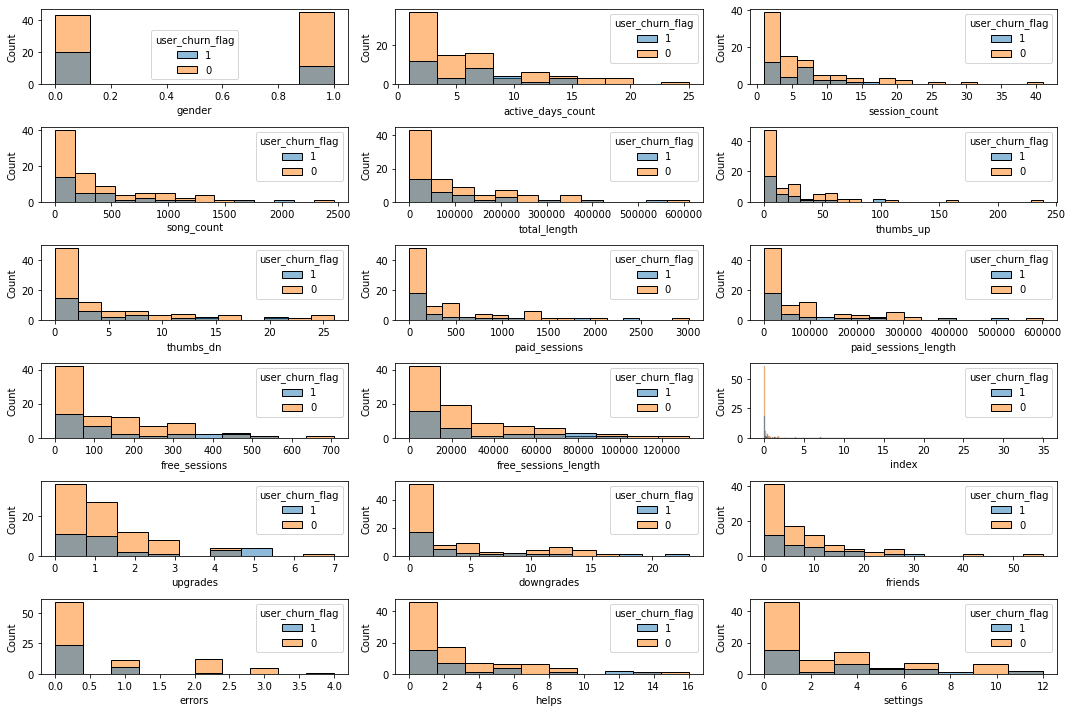

In [65]:
# Check feature distributions to choose correct scaling 
features = feature_dataset.columns[1:]
feature_count = len(features)
ny = 3
nx, r = divmod(feature_count, ny)
if r != 0:
    nx = nx+ 1
indices = list(itertools.product(range(nx), range(ny)))
fig, ax = plt.subplots(nx,ny, figsize = [15,10])

for i,f in enumerate(features):
    ix, iy = indices[i]
    feature = final_dataset.select(f,'user_churn_flag').toPandas()
    axi = ax[ix][iy]
    sns.histplot(feature,x=f, hue='user_churn_flag', ax = axi, hue_order=[1,0])
    #axi.set_title(f)
    plt.tight_layout()

In [16]:
# Feature scaling 
def feature_scaling(df):
    
    # extract feature names
    features = df.columns[1:-1]
    
    # apply logarithm transformation
    df_log = df.select('userId', *[log(col(col_name)+lit(1)).alias(col_name) for col_name in features],'user_churn_flag')
    
    # assemble features in a vector
    assembler = VectorAssembler(inputCols=df_log.columns[1:-1], outputCol="FeatureVec")
    df_log_vec = assembler.transform(df_log)
    df_log_vec = df_log_vec.select(col("FeatureVec").alias("features"),col('user_churn_flag').alias('label'))
    
    # scale features
    min_max_scaler = MinMaxScaler(inputCol = "features", outputCol = "FeatureVecScaled")
    scalerModel = min_max_scaler.fit(df_log_vec)
    df_scaled = scalerModel.transform(df_log_vec)
    df_scaled = df_scaled.select(col("FeatureVecScaled").alias("features"),col('label'))
    
    return df_scaled

In [17]:
final_scaled = feature_scaling(final_dataset)

In [18]:
final_scaled.persist()

DataFrame[features: vector, label: int]

In [19]:
final_scaled.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: integer (nullable = true)



In [20]:
final_scaled.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[1.0,0.4056188482...|    0|
|[0.0,0.4400812399...|    0|
|[0.0,0.0,0.0,0.09...|    1|
|[1.0,0.8537168130...|    0|
|[0.0,0.5895448077...|    1|
|[0.0,0.4056188482...|    0|
|[0.0,0.6587103086...|    0|
|[1.0,0.8112376965...|    1|
|[1.0,0.4400812399...|    0|
|[0.0,0.3665486109...|    1|
|[1.0,0.7146115712...|    0|
|[1.0,0.2028094241...|    0|
|[0.0,0.5693580350...|    1|
|[1.0,0.6261665608...|    0|
|[0.0,0.6737183239...|    0|
|[1.0,0.9418177996...|    0|
|[0.0,0.3214453320...|    1|
|[0.0,0.7923542318...|    1|
|[1.0,0.5476746241...|    0|
|[0.0,0.4400812399...|    0|
+--------------------+-----+
only showing top 20 rows



In [21]:
# Churn proportion on full dataset
final_scaled.select('label').agg(avg('label')).show()

+------------------+
|        avg(label)|
+------------------+
|0.2311111111111111|
+------------------+



In [22]:
# Split training and validation datasets
training_dataset, validation_dataset = final_scaled.randomSplit([0.8,0.2])

In [23]:
# Churn proportion on training dataset
training_dataset.select('label').agg(avg('label')).show()

+-------------------+
|         avg(label)|
+-------------------+
|0.24719101123595505|
+-------------------+



In [24]:
# Churn proportion on validation dataset
validation_dataset.select('label').agg(avg('label')).show()

+------------------+
|        avg(label)|
+------------------+
|0.1702127659574468|
+------------------+



Let's create a balanced dataset out of the training datset in order to train the models

In [25]:
# Balance modelling dataset to have same proportion of churning vs non-churning customers
churned = training_dataset.select('label').where(col('label')==1).count()
not_churned = training_dataset.select('label').where(col('label')==0).count()
ratio = int(not_churned/churned)
a = range(ratio)
# duplicate the minority rows
minor_df = training_dataset.where(col('label')==1)
major_df = training_dataset.where(col('label')==0)
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')
#combine both oversampled minority rows and previous majority rows 
combined_df = major_df.unionAll(oversampled_df)

In [26]:
balanced_training_dataset = combined_df

# Modeling

In [27]:
model_names = []
metrics_valid = dict()

In [28]:
def report_results(model, results_valid, train_time_start, train_time_end):
    
    evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')
    evaluator.setLabelCol('label')
    metrics = ["weightedRecall","weightedPrecision", "accuracy", "f1" ]
    #metrics_test = []
    metrics_valid = []
    
    for m in metrics: 
        metric_valid_output = evaluator.evaluate(results_valid, {evaluator.metricName : m})
        metrics_valid.append(metric_valid_output)
    
    train_time = (train_time_end-train_time_start)/60
    
    print(model)
    print('Total training time: {} minutes'.format((train_time_end-train_time_start)/60))
    print(10*'==')
    print('Results on validation dataset')
    print(10*'-')
    print('Recall: {}'.format(metrics_valid[0]))
    print('Precision: {}'.format(metrics_valid[1]))
    print('Accuracy: {}'.format(metrics_valid[2]))
    print('F-1 Score: {}'.format(metrics_valid[3]))
    
    return metrics_valid, train_time
    

### Baseline model: nobody churns

In [29]:
model_name = 'Baseline'
model_names.append(model_name)
bl_results_valid = validation_dataset.withColumn('prediction',lit(0).cast(DoubleType())) 

In [30]:
bl_metrics_valid, bl_train_time = report_results(model_name, bl_results_valid, 0, 0)
metrics_valid[model_name] = bl_metrics_valid+[bl_train_time]

Baseline
Total training time: 0.0 minutes
Results on validation dataset
----------
Recall: 0.8297872340425532
Precision: 0.688546853779991
Accuracy: 0.8297872340425532
F-1 Score: 0.7525977238990599


In [31]:
def get_precision_recall(results_valid):
    true_positives = results_valid.where(col('prediction') == 1.0).where( col('label') == 1).count()
    false_positives = results_valid.where(col('prediction') == 1.0).where( col('label') == 0).count()
    false_negatives = results_valid.where(col('prediction') == 0.0).where( col('label') == 1).count()
    true_negatives = results_valid.where(col('prediction') == 0.0).where(col('label') == 0).count()
    
    if false_positives+true_positives == 0:
        precision = 'no user labelled churning'
    else:
        precision = true_positives/(false_positives+true_positives)
    recall = true_positives/(false_negatives+true_positives)
    print('precision: {}\nrecall: {}'.format(precision,recall))
    return precision, recall

In [32]:
p,r = get_precision_recall(bl_results_valid)

precision: no user labelled churning
recall: 0.0


### Logistic Regression

In [34]:
model_name = 'Logistic Regression'
numFolds = 3
lr = LogisticRegression(maxIter=10, labelCol='label', featuresCol='features')
evaluator = MulticlassClassificationEvaluator(labelCol='label')

pipeline = Pipeline(stages=[lr])
lr_paramGrid = (ParamGridBuilder()
                .addGrid(lr.regParam, [0.1, 0.01, 0.001])
                .build())

crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=lr_paramGrid,
    evaluator=evaluator,
    numFolds=numFolds)

lr_start = time.time()
lr_model = crossval.fit(balanced_training_dataset)
lr_end = time.time()

In [35]:
model_name = 'Logistic Regression'
model_names.append(model_name)
lr_results_valid = lr_model.transform(validation_dataset)
lr_metrics_valid, lr_train_time = report_results(model_name, lr_results_valid, lr_start, lr_end)
metrics_valid[model_name] = lr_metrics_valid+[lr_train_time]

Logistic Regression
Total training time: 22.71501404841741 minutes
Results on validation dataset
----------
Recall: 0.6170212765957447
Precision: 0.7801418439716311
Accuracy: 0.6170212765957447
F-1 Score: 0.6642718983144517


In [36]:
p,r = get_precision_recall(lr_results_valid)

precision: 0.25
recall: 0.625


### Random Forest

In [37]:
model_name = 'Random Forest'
numFolds = 2
rf = RandomForestClassifier(labelCol='label', featuresCol='features')
evaluator = MulticlassClassificationEvaluator(labelCol='label')

pipeline = Pipeline(stages=[rf])
rf_paramGrid = (ParamGridBuilder()
                .addGrid(rf.numTrees, [10, 30, 50])
                .addGrid(rf.maxDepth, [10,20])
                .addGrid(rf.subsamplingRate, [1])
                .build())

crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=rf_paramGrid,
    evaluator=evaluator,
    numFolds=numFolds)

rf_start = time.time()
rf_model = crossval.fit(balanced_training_dataset)
rf_end = time.time()

In [38]:
model_name = 'Random Forest'
model_names.append(model_name)
rf_results_valid = rf_model.transform(validation_dataset)
rf_metrics_valid, rf_train_time =report_results(model_name, rf_results_valid, rf_start, rf_end)
metrics_valid[model_name] = rf_metrics_valid+[rf_train_time]

Random Forest
Total training time: 43.09783849716187 minutes
Results on validation dataset
----------
Recall: 0.7872340425531915
Precision: 0.6822695035460992
Accuracy: 0.7872340425531915
F-1 Score: 0.7310030395136777


In [40]:
nt, md, si = list(rf_model.getEstimatorParamMaps()[np.argmax(rf_model.avgMetrics)].values())
print('Best model for number of trees: {} and max depth {}'.format(nt,md))

Best model for number of trees: 50 and max depth 20


In [41]:
p,r = get_precision_recall(rf_results_valid)

precision: 0.0
recall: 0.0


### Gradient Boosted Trees

In [48]:
model_name = 'Gradient Boosted Trees'
numFolds = 3
gbt = GBTClassifier(labelCol='label', featuresCol='features')
evaluator = MulticlassClassificationEvaluator(labelCol='label')

pipeline = Pipeline(stages=[gbt])
gbt_paramGrid = (ParamGridBuilder()
                 .addGrid(gbt.maxIter, [10,20])
                 .addGrid(gbt.maxDepth, [10,20])
                 .build())

crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=gbt_paramGrid,
    evaluator=evaluator,
    numFolds=numFolds)

gbt_start = time.time()
gbt_model = crossval.fit(balanced_training_dataset)
gbt_end = time.time()

In [49]:
model_name = 'Gradient Boosted Trees'
model_names.append(model_name)
gbt_results_valid = gbt_model.transform(validation_dataset)
gbt_metrics_valid, gbt_train_time = report_results(model_name, gbt_results_valid, gbt_start, gbt_end)
metrics_valid[model_name] = gbt_metrics_valid+[gbt_train_time]

Gradient Boosted Trees
Total training time: 587.7982557972272 minutes
Results on validation dataset
----------
Recall: 0.6382978723404256
Precision: 0.7341755319148937
Accuracy: 0.6382978723404256
F-1 Score: 0.675509113887767


In [50]:
p,r = get_precision_recall(gbt_results_valid)

precision: 0.2
recall: 0.375


### Support Vector Machines

In [42]:
model_name = 'Support Vector Machines'
numFolds = 3
svc = LinearSVC(labelCol='label', featuresCol='features')
evaluator = MulticlassClassificationEvaluator(labelCol='label')

pipeline = Pipeline(stages=[svc])
svc_paramGrid = (ParamGridBuilder()
                 .addGrid(svc.maxIter, [5,10])
                 .build())

crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=svc_paramGrid,
    evaluator=evaluator,
    numFolds=numFolds)

svc_start = time.time()
svc_model = crossval.fit(balanced_training_dataset)
svc_end = time.time()

In [43]:
model_name = 'Support Vector Machines'
model_names.append(model_name)
svc_results_valid = svc_model.transform(validation_dataset)
svc_metrics_valid, svc_train_time = report_results(model_name, svc_results_valid, svc_start, svc_end)
metrics_valid[model_name] = svc_metrics_valid+[svc_train_time]

Support Vector Machines
Total training time: 19.112257599830627 minutes
Results on validation dataset
----------
Recall: 0.46808510638297873
Precision: 0.7368400315208826
Accuracy: 0.46808510638297873
F-1 Score: 0.5268146927000156


In [44]:
p,r = get_precision_recall(svc_results_valid)

precision: 0.18518518518518517
recall: 0.625


### Naive Bayes

In [45]:
model_name = 'Naive Bayes'
numFolds = 3
nb = NaiveBayes(labelCol='label', featuresCol='features', modelType="multinomial")
evaluator = MulticlassClassificationEvaluator(labelCol='label')

pipeline = Pipeline(stages=[nb])
nb_paramGrid = (ParamGridBuilder()
                 .addGrid(nb.smoothing, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.5, 2.0])
                 .build())

crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=nb_paramGrid,
    evaluator=evaluator,
    numFolds=numFolds)

nb_start = time.time()
nb_model = crossval.fit(balanced_training_dataset)
nb_end = time.time()

In [46]:
model_name = 'Naive Bayes'
model_names.append(model_name)
nb_results_valid = nb_model.transform(validation_dataset)
nb_metrics_valid, nb_train_time = report_results(model_name, nb_results_valid, nb_start, nb_end)
metrics_valid[model_name] = nb_metrics_valid+[nb_train_time]

Naive Bayes
Total training time: 11.936249387264251 minutes
Results on validation dataset
----------
Recall: 0.5106382978723404
Precision: 0.7210915818686402
Accuracy: 0.5106382978723404
F-1 Score: 0.570774912573128


In [47]:
p,r = get_precision_recall(nb_results_valid)

precision: 0.17391304347826086
recall: 0.5


# Comparison between model performances 

In [51]:
def plot_model_performance_comparison(model_names, metrics_valid):
    
    metrics = ["Weighted Recall","Weighted Precision", "Accuracy", "F1 score" ,'Training time']
    model_count = len(model_names)

    fig, ax = plt.subplots(5,1, figsize = [5,20])

    for i,m in enumerate(metrics):

        # validation metrics
        axi = ax[i]
        axi.bar(x=model_names, height = [metrics_valid[model][i] for model in model_names])
        axi.set_title(m)
        axi.set_xticklabels(model_names,rotation = 45)
        axi.grid()
#        axi.set_xticks()
        
    plt.tight_layout()

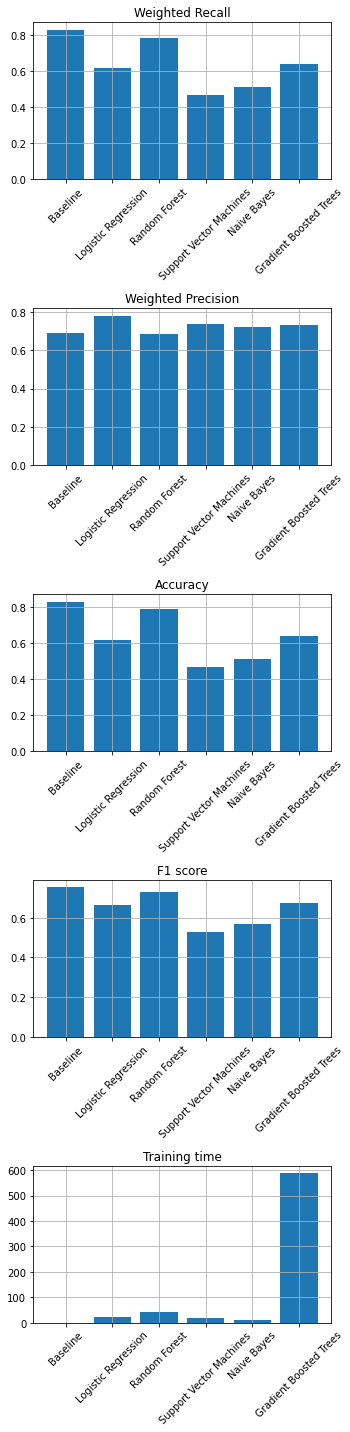

In [52]:
plot_model_performance_comparison(model_names,metrics_valid)

# Conclusion